In [1]:
from pyspark.sql import functions as F, SparkSession
from pyspark.sql.window import Window
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.functions import vector_to_array

import pandas as pd

import os
os.sys.path.append("../")
from scripts.consumer_transaction_model import *



In [2]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = "/usr/local/bin/python3.11"
os.environ['PYSPARK_DRIVER_PYTHON'] = "/usr/local/bin/python3.11"

In [3]:
# Create a Spark Session
spark = (
    SparkSession.builder.appName("consumer transaction model")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.execturo.memory", "2g")
    .getOrCreate()
)

24/09/28 17:18:09 WARN Utils: Your hostname, qinsitaodeMacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.4.51 instead (on interface en0)
24/09/28 17:18:09 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/28 17:18:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load data

In [4]:
consumer_info = spark.read.parquet('../data/curated/consumer_info.parquet')
transaction_records = spark.read.parquet('../data/curated/transactions.parquet')
fraudulent_consumer_rate = spark.read.parquet('../data/curated/consumer_fraud_prob.parquet')
personal_fraud = spark.read.csv('../data/curated/personal_fraud.csv', header=True, inferSchema=True)
postcode_info = spark.read.csv('../data/curated/postcode_info.csv', header=True, inferSchema=True)

personal_fraud = personal_fraud.drop(personal_fraud.columns[0])
postcode_info = postcode_info.drop(postcode_info.columns[0])

24/09/28 17:18:23 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


# Prepare data frame for modelling

In [5]:
# Add consumer info to transaction records
consumer_transaction_records = transaction_records.join(consumer_info, on="consumer_id", how="inner")

In [6]:
# Merge transaction with consumer infomation
transaction_fraudulent_consumer = transaction_records.join(fraudulent_consumer_rate, on=["order_datetime", "consumer_id"], how="inner")
transaction_fraudulent_consumer_with_info = consumer_info.join(transaction_fraudulent_consumer, on="consumer_id", how="inner")

In [7]:
# number of unique available fraudulent consumer (does not lost any consumer after merging with transaction records)
transaction_fraudulent_consumer_with_info.select("consumer_id").distinct().count()

20128

In [8]:
# Average fraud probability in each postcode or state
fraudulent_consumer_group_by_postcode = transaction_fraudulent_consumer_with_info.groupBy(["postcode"]).agg(F.avg("fraud_probability").alias("average_fraud_prob_of_postcode"))

fraudulent_consumer_group_by_state = transaction_fraudulent_consumer_with_info.groupBy(["state"]).agg(F.avg("fraud_probability").alias("average_fraud_prob_of_state"))

In [9]:
# analysis order value, consider the variance of order value and purchase frequency
consumer_transaction_value_analysis =  consumer_transaction_records.groupBy("consumer_id", "state", "postcode") \
                                        .agg(
                                            F.avg("dollar_value").alias("average_dollar_value"),
                                            F.min("dollar_value").alias("min_dollar_value"),
                                            F.max("dollar_value").alias("max_dollar_value"),
                                            F.count("dollar_value").alias("transaction_count"),
                                            F.stddev("dollar_value").alias("stddev_dollar_value")
                                        )

In [10]:
transaction_fraudulent_consumer_summary = transaction_fraudulent_consumer_with_info \
    .join(consumer_transaction_value_analysis, on=["consumer_id", "state","postcode"], how="left") \
    .join(fraudulent_consumer_group_by_postcode, on="postcode", how="inner") \
    .join(fraudulent_consumer_group_by_state, on="state", how="inner")

### missing 2755 in postcode_info

In [11]:
# Get infomation about personal fraud and income from external dataset
postcode_info = postcode_info.drop("state", "long", "lat", "lgacode")
transaction_fraudulent_consumer_summary = transaction_fraudulent_consumer_summary.join(personal_fraud, on="state", how="inner")
transaction_fraudulent_consumer_summary = transaction_fraudulent_consumer_summary.join(postcode_info, on="postcode", how="inner")

In [12]:
# Get proportion of the money used to purchase item with respect to income (one and a half year)
# average income
transaction_fraudulent_consumer_summary = transaction_fraudulent_consumer_summary.withColumn("Proportion_between_max_order_value_mean_income", F.col("max_dollar_value") / (F.col("mean_income") * 1.5) )
transaction_fraudulent_consumer_summary = transaction_fraudulent_consumer_summary.withColumn("Proportion_between_max_order_value_median_income", F.col("max_dollar_value") / (F.col("median_income") * 1.5))

# Total income
transaction_fraudulent_consumer_summary = transaction_fraudulent_consumer_summary.withColumn("Proportion_between_total_order_value_mean_income", F.col("average_dollar_value") * F.col("transaction_count") / (F.col("mean_income") * 1.5))
transaction_fraudulent_consumer_summary = transaction_fraudulent_consumer_summary.withColumn("Proportion_between_total_order_value_median_income", F.col("average_dollar_value") * F.col("transaction_count") / (F.col("median_income") * 1.5))


In [13]:
transaction_fraudulent_consumer_summary.count()

80537

### Analysis datetime information

In [14]:
# Convert 'order_datetime' from string to date format
transaction_fraudulent_consumer_summary = transaction_fraudulent_consumer_summary.withColumn("order_datetime", F.to_date("order_datetime", "yyyy-MM-dd"))
cutoff_date = "2021-03-07"
transaction_fraudulent_consumer_summary = transaction_fraudulent_consumer_summary.filter(F.col("order_datetime") >= F.lit(cutoff_date))

# Add a new column 'transaction_count_last_n_days' that counts the transactions within n days before each transaction
window_spec = Window.partitionBy("consumer_id").orderBy(F.col("order_datetime").cast("long")) \
    .rangeBetween(-7 * 86400, 0)  # 7 days in seconds (86400 seconds = 1 day)

transaction_fraudulent_consumer_summary = transaction_fraudulent_consumer_summary.withColumn("transaction_count_last_7_days", F.count("order_datetime").over(window_spec))



In [15]:
# Return the corresponding day of the week for the given date in the DataFrame.

transaction_fraudulent_consumer_summary = transaction_fraudulent_consumer_summary.withColumn("day_of_week", F.date_format("order_datetime", "EEEE"))
transaction_fraudulent_consumer_summary = transaction_fraudulent_consumer_summary.withColumn("is_weekend", F.date_format("order_datetime", "EEEE").isin("Saturday", "Sunday"))

transaction_fraudulent_consumer_summary = transaction_fraudulent_consumer_summary.withColumn("month", F.month("order_datetime"))


Month has a weak relatinonship with fraud probability

In [16]:
monthly_summary = transaction_fraudulent_consumer_summary.withColumn("month", F.month("order_datetime")) \
    .groupBy("month") \
    .agg(
        F.count("*").alias("count"),
        F.avg("fraud_probability").alias("average_fraud_probability")
    )

monthly_summary.show()

+-----+-----+-------------------------+
|month|count|average_fraud_probability|
+-----+-----+-------------------------+
|   12|17145|       14.767484927895836|
|    1| 6684|       15.112982769460368|
|    6| 1685|       14.063442005168794|
|    3| 1118|        14.65283629958641|
|    5| 1683|       14.867520097261291|
|    9| 9240|       14.955936655148621|
|    4| 1437|       14.635964221334742|
|    8| 2948|       15.018070377044475|
|    7| 1927|       14.703204674679945|
|   10|10349|       15.023729053696435|
|   11|19699|       14.942338145883355|
|    2| 6373|        15.24098857146153|
+-----+-----+-------------------------+



# Feature engineering

## Standardizes features

In [17]:
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.functions import vector_to_array



cols_to_scale = ["dollar_value", "min_dollar_value", "max_dollar_value", "stddev_dollar_value","average_dollar_value"]
cols_to_keep_unscaled = [col for col in transaction_fraudulent_consumer_summary.columns if col not in cols_to_scale] + ["dollar_value"]

assembler = VectorAssembler(inputCols=cols_to_scale, outputCol="features")
sdf_transformed = assembler.transform(transaction_fraudulent_consumer_summary)
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(sdf_transformed.select("features"))
sdf_scaled = scaler_model.transform(sdf_transformed)
scaled_array_col = vector_to_array(F.col("scaledFeatures"))

# Create new columns for each scaled feature
for i, col in enumerate(cols_to_scale):
    sdf_scaled = sdf_scaled.withColumn(f"scaled_{col}", scaled_array_col[i])

# Combine original Dataframe and the scaled features
dollar_value_df = transaction_fraudulent_consumer_summary.select("dollar_value")
transaction_fraudulent_consumer_summary = sdf_scaled.select(cols_to_keep_unscaled + [f"scaled_{col}" for col in cols_to_scale])


## Features Log transformation 

In [29]:
cols_to_log = ['scaled_dollar_value', 'scaled_average_dollar_value', 'scaled_min_dollar_value',
                'scaled_max_dollar_value', 'scaled_stddev_dollar_value',
                "Proportion_between_max_order_value_mean_income",
                "Proportion_between_max_order_value_median_income",
                "Proportion_between_total_order_value_mean_income",
                "Proportion_between_total_order_value_median_income"
                ] 


for col in cols_to_log:
    transaction_fraudulent_consumer_summary = transaction_fraudulent_consumer_summary \
        .withColumn(f'{col}', F.when(transaction_fraudulent_consumer_summary[col] > 0, F.log(transaction_fraudulent_consumer_summary[col])).otherwise(None))

In [ ]:
transaction_fraudulent_consumer_summary.show(4)

# Visualisation

## Assumptions or Observations:
1. The gender plot shows that there is a similar number of male and female consumers.
2. The number of consumers varies significantly across different states.
3. Consumers make a similar number of purchases on each day of the week, whether it’s a weekday or a weekend.
4. Both fraud probability and the dollar value of an order are strongly right-skewed and should be normalized.
5. Proportion features exhibit a linear relationship with fraud probability but may need transformation to clarify this relationship.

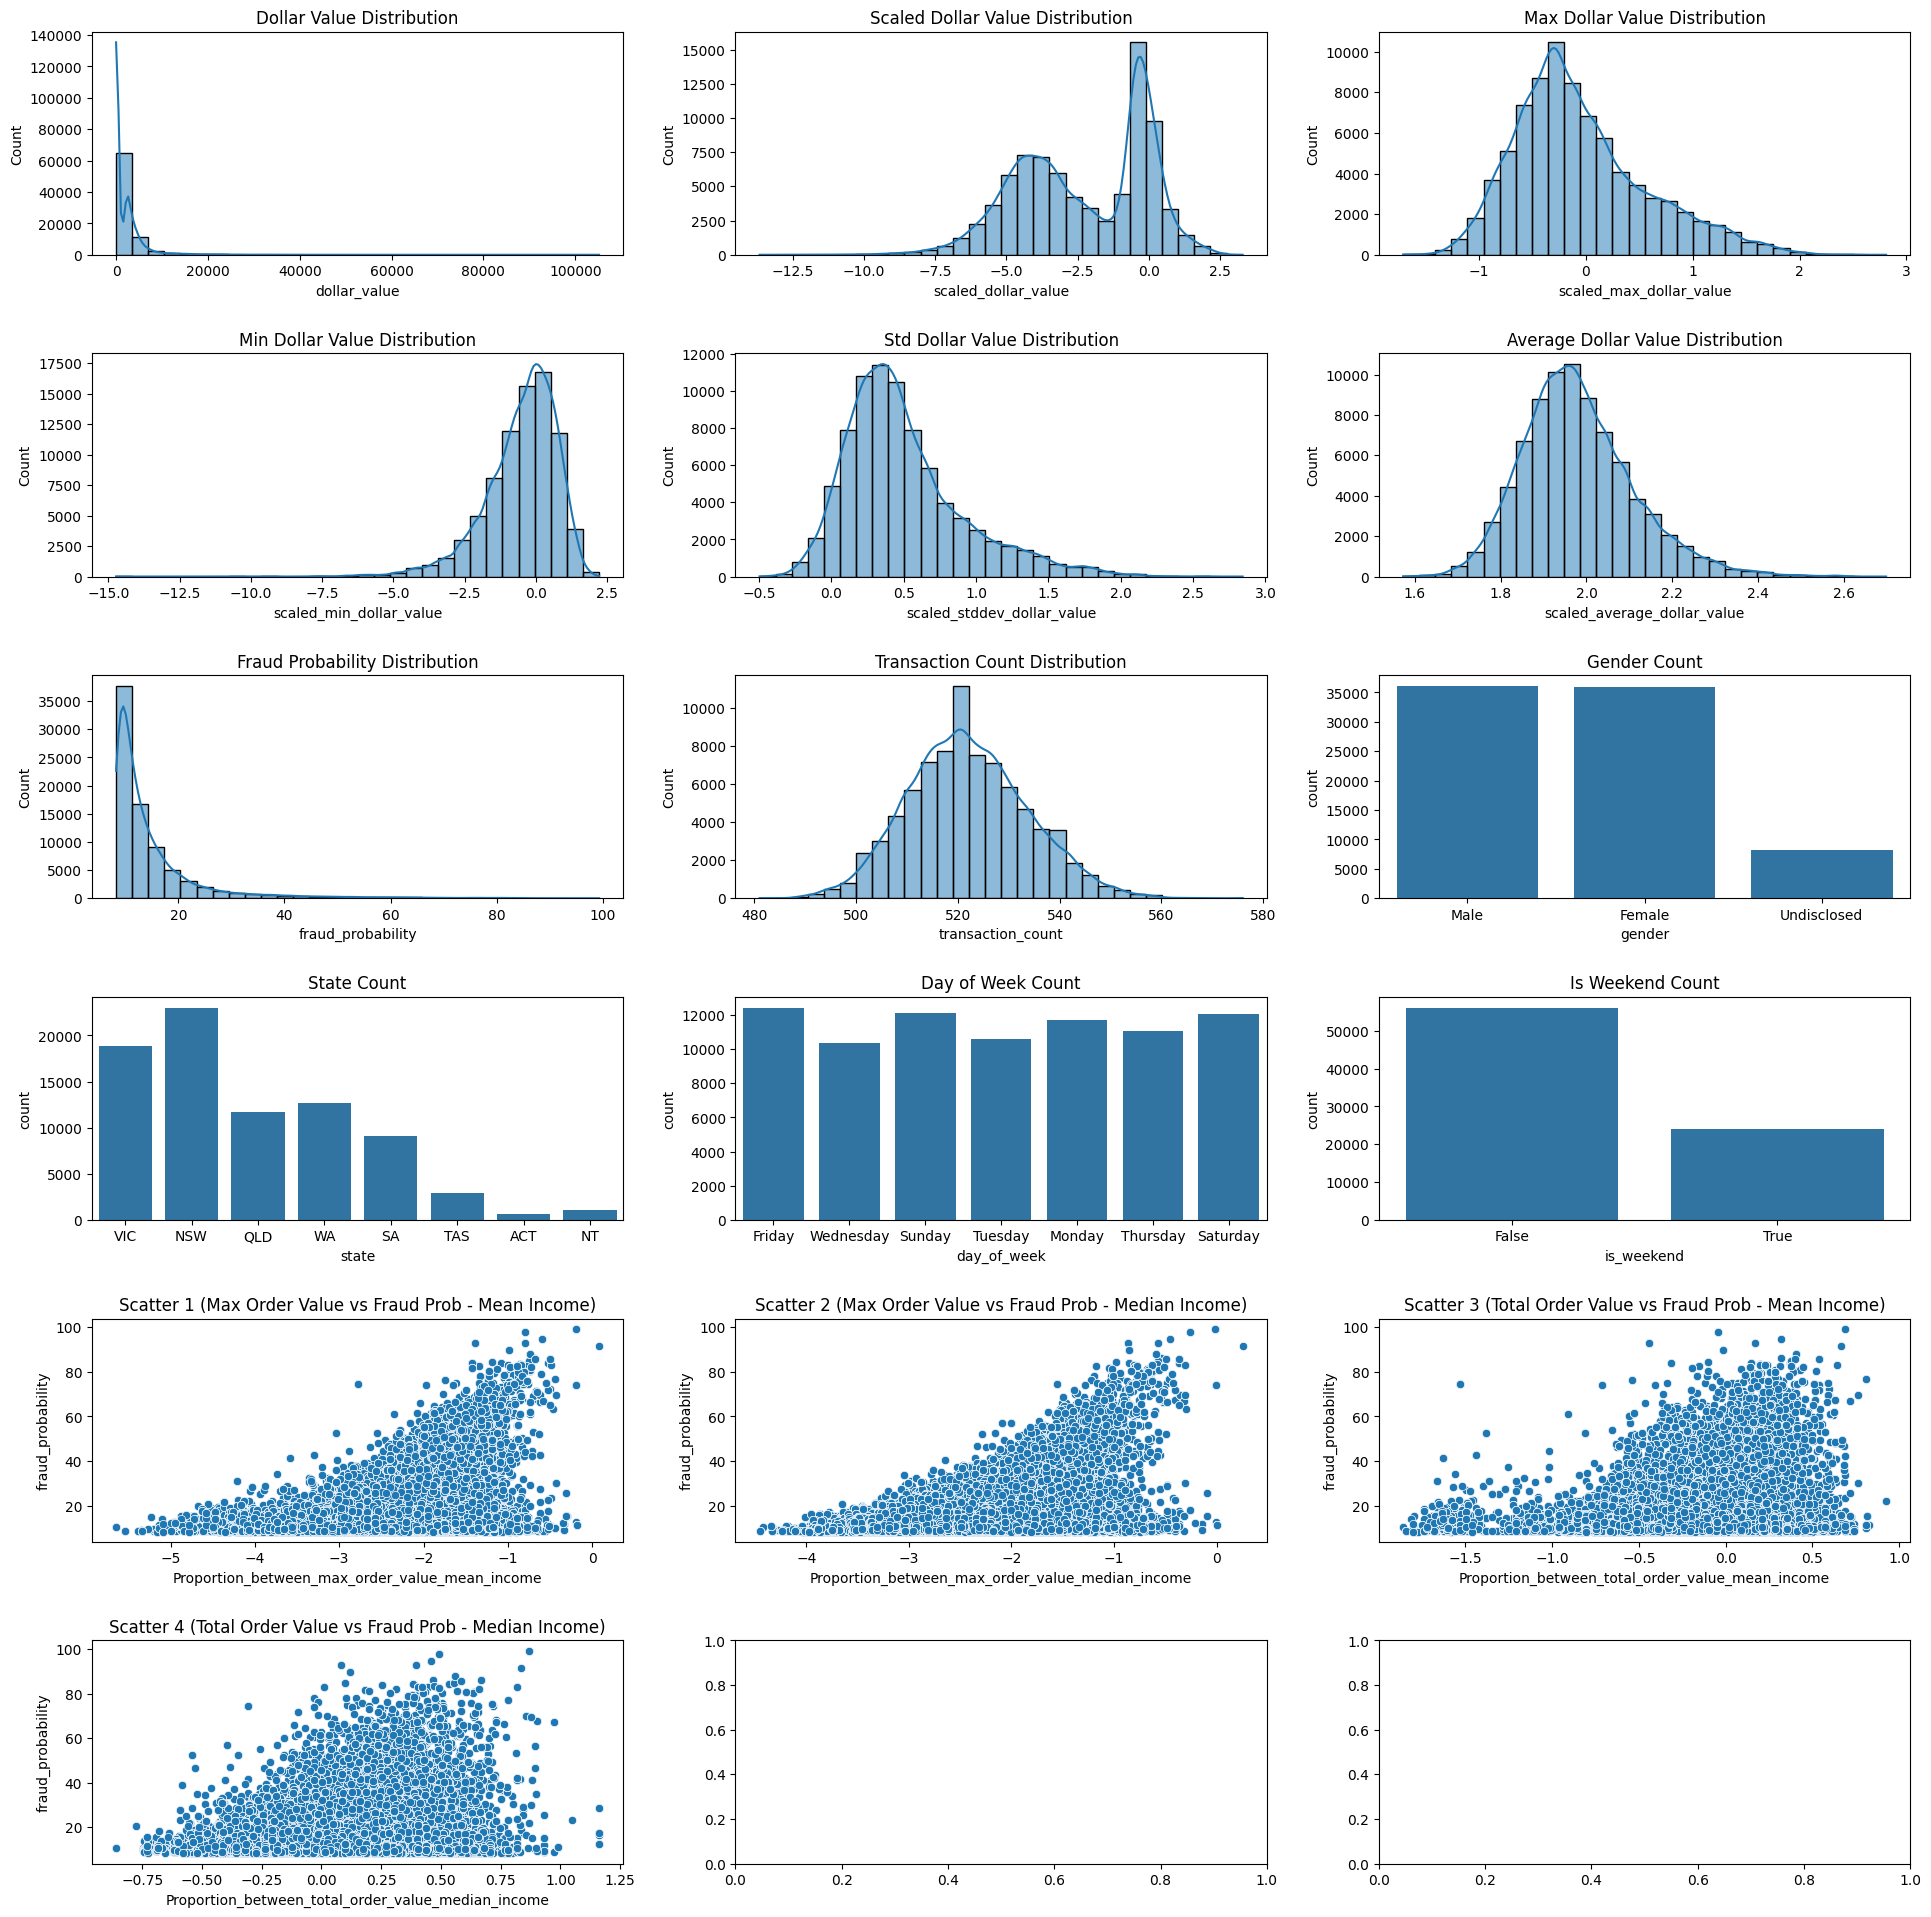

In [30]:
# Convert relevant columns to Pandas
df_pandas = transaction_fraudulent_consumer_summary.select(
    "dollar_value", "scaled_dollar_value", "fraud_probability", "scaled_average_dollar_value", 
    "scaled_min_dollar_value", "scaled_max_dollar_value", "transaction_count", 
    "median_income", "mean_income", "state", "gender", "scaled_stddev_dollar_value",
    "day_of_week", "is_weekend", "Proportion_between_max_order_value_mean_income",
    "Proportion_between_max_order_value_median_income", 
    "Proportion_between_total_order_value_mean_income", 
    "Proportion_between_total_order_value_median_income"
).toPandas()

# Define plots in a dictionary for looping
plots = {
    "Dollar Value Distribution": ("dollar_value", "hist"),
    "Scaled Dollar Value Distribution": ("scaled_dollar_value", "hist"),
    "Max Dollar Value Distribution": ("scaled_max_dollar_value", "hist"),
    "Min Dollar Value Distribution": ("scaled_min_dollar_value", "hist"),
    "Std Dollar Value Distribution": ("scaled_stddev_dollar_value", "hist"),
    "Average Dollar Value Distribution": ("scaled_average_dollar_value", "hist"),
    "Fraud Probability Distribution": ("fraud_probability", "hist"),
    "Transaction Count Distribution": ("transaction_count", "hist"),
    "Gender Count": ("gender", "count"),
    "State Count": ("state", "count"),
    "Day of Week Count": ("day_of_week", "count"),
    "Is Weekend Count": ("is_weekend", "count"),
    "Scatter 1 (Max Order Value vs Fraud Prob - Mean Income)": ("Proportion_between_max_order_value_mean_income", "scatter1"),
    "Scatter 2 (Max Order Value vs Fraud Prob - Median Income)": ("Proportion_between_max_order_value_median_income", "scatter2"),
    "Scatter 3 (Total Order Value vs Fraud Prob - Mean Income)": ("Proportion_between_total_order_value_mean_income", "scatter3"),
    "Scatter 4 (Total Order Value vs Fraud Prob - Median Income)": ("Proportion_between_total_order_value_median_income", "scatter4")
}
feature_visualisation(df_pandas, plots)


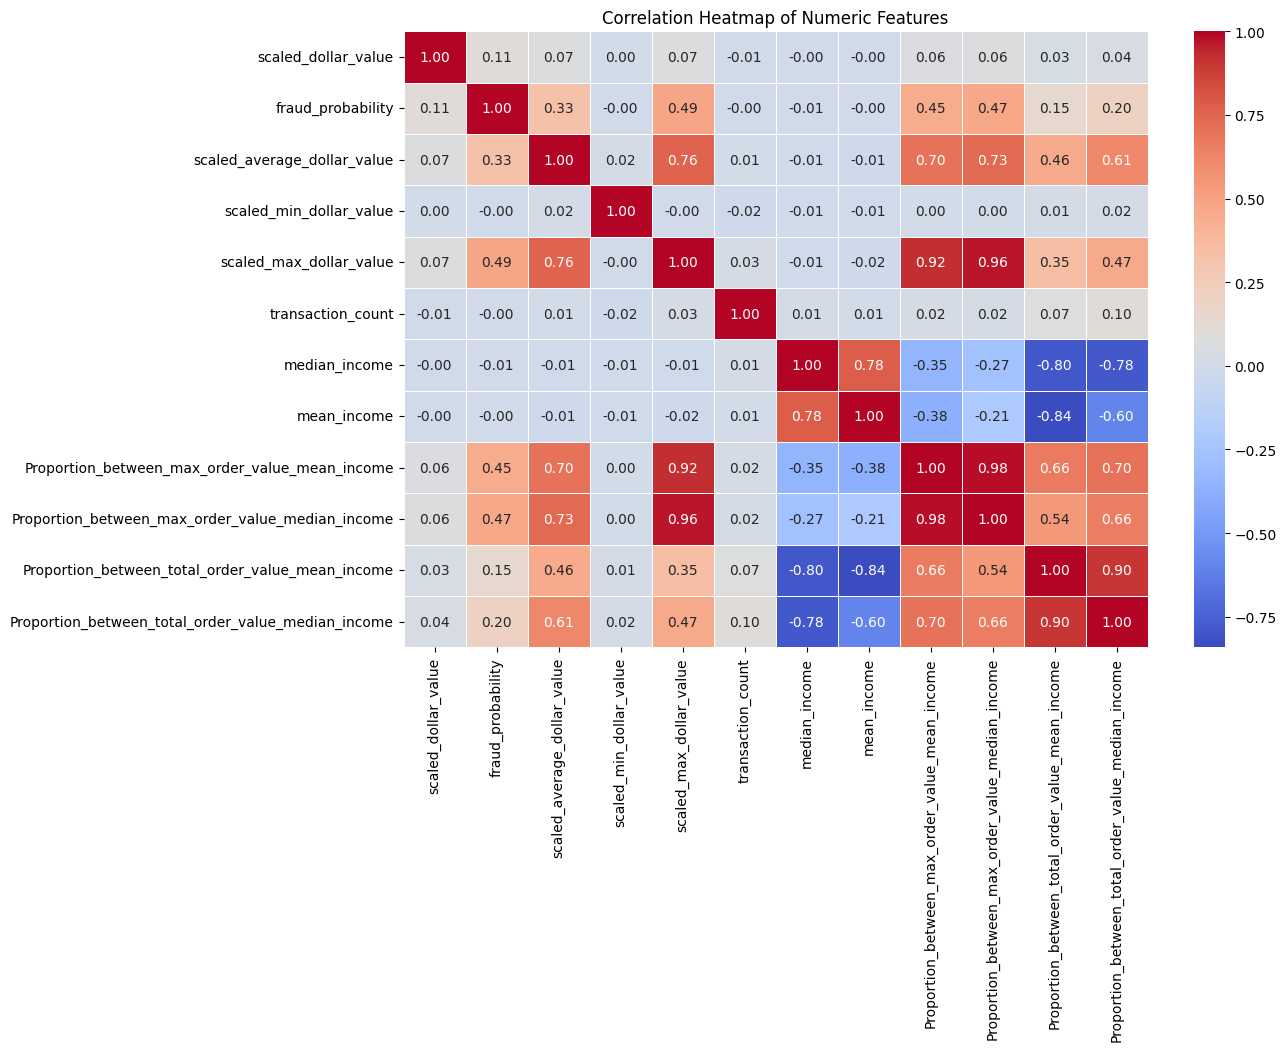

In [31]:
df_pandas = transaction_fraudulent_consumer_summary.select(
    "scaled_dollar_value", "fraud_probability", "scaled_average_dollar_value", 
    "scaled_min_dollar_value", "scaled_max_dollar_value", "transaction_count", 
    "median_income", "mean_income", "Proportion_between_max_order_value_mean_income",
    "Proportion_between_max_order_value_median_income", 
    "Proportion_between_total_order_value_mean_income", 
    "Proportion_between_total_order_value_median_income"
).toPandas()
corr_matrix = df_pandas.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


# Idea
1. Time Frequency feature: https://ieeexplore.ieee.org/document/9399421/

# Modelling

In [32]:
transaction_fraudulent_consumer_summary.printSchema()

root
 |-- postcode: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- consumer_id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- order_id: string (nullable = true)
 |-- fraud_probability: double (nullable = true)
 |-- transaction_count: long (nullable = true)
 |-- average_fraud_prob_of_postcode: double (nullable = true)
 |-- average_fraud_prob_of_state: double (nullable = true)
 |-- victimisation_rate: double (nullable = true)
 |-- rse_percent: double (nullable = true)
 |-- median_age: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- mean_income: double (nullable = true)
 |-- Proportion_between_max_order_value_mean_income: double (nullable = true)
 |-- Proportion_between_max_order_value_median_income: double (nullable = true)
 |-- Proportion_between_total_order_value_mean_income: double (nullable = true

In [40]:
# List of features to be used in the model

features = ["average_fraud_prob_of_postcode", "victimisation_rate", "rse_percent",
            "Proportion_between_max_order_value_mean_income", "Proportion_between_max_order_value_median_income",
            "Proportion_between_total_order_value_mean_income", "Proportion_between_total_order_value_median_income",
            "transaction_count_last_7_days", "scaled_dollar_value", "scaled_min_dollar_value",
            "scaled_max_dollar_value", "scaled_stddev_dollar_value", "scaled_average_dollar_value", "month_index"]

features_dt = [
    "scaled_dollar_value", "scaled_max_dollar_value", "average_fraud_prob_of_postcode",
    "month", "transaction_count_last_7_days", "scaled_average_dollar_value"

]

features_rf = [
    "scaled_dollar_value", "scaled_max_dollar_value", "average_fraud_prob_of_postcode",
    "scaled_stddev_dollar_value", "Proportion_between_max_order_value_median_income",
    "month", "transaction_count_last_7_days", "Proportion_between_max_order_value_mean_income"

]

features_lr = [
    "transaction_count_last_7_days",
    "Proportion_between_total_order_value_mean_income",
    "scaled_max_dollar_value",
    "scaled_average_dollar_value",
    "scaled_stddev_dollar_value",
    "Proportion_between_max_order_value_median_income",
    "average_fraud_prob_of_postcode",
    "Proportion_between_max_order_value_mean_income"
]

In [38]:
transaction_fraudulent_consumer_summary = transaction_fraudulent_consumer_summary.withColumn("is_weekend", transaction_fraudulent_consumer_summary["is_weekend"].cast("integer"))

In [42]:
month_index = StringIndexer(inputCol="month", outputCol="month_index")


# day_of_week_index, 
# is_weekend_index, 
assembler_dt = VectorAssembler(inputCols=features_dt, outputCol="features")
pipeline_dt = Pipeline(stages = [month_index, assembler_dt])

assembler_rf = VectorAssembler(inputCols=features_rf, outputCol="features")
pipeline_rf = Pipeline(stages = [month_index, assembler_rf])

assembler_lr = VectorAssembler(inputCols=features_lr, outputCol="features")
pipeline_lr = Pipeline(stages = [month_index, assembler_lr])

data_dt = pipeline_dt.fit(transaction_fraudulent_consumer_summary).transform(transaction_fraudulent_consumer_summary)
data_rf = pipeline_rf.fit(transaction_fraudulent_consumer_summary).transform(transaction_fraudulent_consumer_summary)
data_lr = pipeline_lr.fit(transaction_fraudulent_consumer_summary).transform(transaction_fraudulent_consumer_summary)

train_data_dt, test_data_dt = data_dt.randomSplit([0.8, 0.2])
train_data_rf, test_data_rf = data_rf.randomSplit([0.8, 0.2])
train_data_lr, test_data_lr = data_lr.randomSplit([0.8, 0.2])


In [43]:
data_rf.printSchema()

root
 |-- postcode: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- consumer_id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- order_id: string (nullable = true)
 |-- fraud_probability: double (nullable = true)
 |-- transaction_count: long (nullable = true)
 |-- average_fraud_prob_of_postcode: double (nullable = true)
 |-- average_fraud_prob_of_state: double (nullable = true)
 |-- victimisation_rate: double (nullable = true)
 |-- rse_percent: double (nullable = true)
 |-- median_age: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- mean_income: double (nullable = true)
 |-- Proportion_between_max_order_value_mean_income: double (nullable = true)
 |-- Proportion_between_max_order_value_median_income: double (nullable = true)
 |-- Proportion_between_total_order_value_mean_income: double (nullable = true

In [44]:
# Define model regressor
dt = DecisionTreeRegressor(labelCol="fraud_probability", featuresCol="features")

rf = RandomForestRegressor(labelCol="fraud_probability", featuresCol="features")

lr = LinearRegression(labelCol="fraud_probability", featuresCol="features")


In [45]:
# Parameter grid
dt_param_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [3, 5, 7]) \
    .addGrid(dt.maxBins, [32, 64]) \
    .build()


rf_param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [5, 7]) \
    .build()

lr_param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()


In [46]:
# Evaluator for regression models
rmse_evaluator = RegressionEvaluator(
    labelCol="fraud_probability", 
    predictionCol="prediction", 
    metricName="rmse"  
)

r2_evaluator = RegressionEvaluator(
    labelCol="fraud_probability",
    predictionCol="prediction",
    metricName="r2" 
)

# Cross-validation 
dt_cv = CrossValidator(
    estimator=dt,
    estimatorParamMaps=dt_param_grid,
    evaluator=r2_evaluator,
    numFolds=3
)

rf_cv = CrossValidator(
    estimator=rf,
    estimatorParamMaps=rf_param_grid,
    evaluator=r2_evaluator,
    numFolds=3
)

lr_cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=lr_param_grid,
    evaluator=r2_evaluator,
    numFolds=3
)


In [47]:
# Pipeline 
dt_pipeline = Pipeline(stages=[dt_cv])

rf_pipeline = Pipeline(stages=[rf_cv])

lr_pipeline = Pipeline(stages=[lr_cv])


In [48]:
# Fit model

# 6 mins
dt_model = dt_pipeline.fit(train_data_dt)




In [49]:
# 7 mins
rf_model = rf_pipeline.fit(train_data_rf)


In [50]:

# 4 mins
lr_model = lr_pipeline.fit(train_data_lr)

24/09/28 18:10:52 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/09/28 18:10:52 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/09/28 18:10:54 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


[3250.254s][warning][gc,alloc] broadcast-exchange-296: Retried waiting for GCLocker too often allocating 2097152 words


24/09/28 18:12:17 WARN TaskMemoryManager: Failed to allocate a page (16777200 bytes), try again.


# Evaluation

In [51]:
# Make predictions on the test data
dt_predictions = dt_model.transform(test_data_dt)
rf_predictions = rf_model.transform(test_data_rf)
lr_predictions = lr_model.transform(test_data_lr)


dt_rmse = rmse_evaluator.evaluate(dt_predictions)
dt_r2 = r2_evaluator.evaluate(dt_predictions)
print(f"Decision Tree RMSE: {dt_rmse}")
print(f"Decision Tree R2: {dt_r2}")         

rf_rmse = rmse_evaluator.evaluate(rf_predictions)
rf_r2 = r2_evaluator.evaluate(rf_predictions)
print(f"Random Forest RMSE: {rf_rmse}")
print(f"Random Forest R2: {rf_r2}")           

lr_rmse = rmse_evaluator.evaluate(lr_predictions)
lr_r2 = r2_evaluator.evaluate(lr_predictions)
print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Linear Regression R2: {lr_r2}")  

# Decision Tree RMSE: 5.7094862590250255
# Decision Tree R2: 0.6422921968307849
                                                                                
# Random Forest RMSE: 5.938801235944556
# Random Forest R2: 0.6261701163519497

# Linear Regression RMSE: 7.9186177588479465
# Linear Regression R2: 0.33878919376163685




Decision Tree RMSE: 5.7094862590250255
Decision Tree R2: 0.6422921968307849


Random Forest RMSE: 5.938801235944556
Random Forest R2: 0.6261701163519497


Linear Regression RMSE: 7.9186177588479465
Linear Regression R2: 0.33878919376163685


`Best model hyperparameters`

In [52]:
best_dt_model = dt_model.stages[-1].bestModel
print(f"Best Decision Tree maxDepth: {best_dt_model._java_obj.getMaxDepth()}")
print(f"Best Decision Tree maxBins: {best_dt_model._java_obj.getMaxBins()}")


best_rf_model = rf_model.stages[-1].bestModel
print(f"Best Random Forest numTrees: {best_rf_model.getNumTrees}")
print(f"Best Random Forest maxDepth: {best_rf_model.getMaxDepth()}")


Best Decision Tree maxDepth: 7
Best Decision Tree maxBins: 64
Best Random Forest numTrees: 10
Best Random Forest maxDepth: 7


### __Feature importances__

In [53]:
feature_names_dt = assembler_dt.getInputCols()
feature_names_rf = assembler_rf.getInputCols()
feature_names_lr = assembler_lr.getInputCols()

`Random forest and decision tree`

In [54]:
best_rf_model = rf_model.stages[0].bestModel
best_dt_model = dt_model.stages[0].bestModel

dt_feature_importances = best_dt_model.featureImportances
rf_feature_importances = best_rf_model.featureImportances

rf_importances_df = pd.DataFrame({
    "Feature": feature_names_rf,
    "Importance": rf_feature_importances.toArray()
}).sort_values(by="Importance", ascending=False)

dt_importances_df = pd.DataFrame({
    "Feature": feature_names_dt,
    "Importance": dt_feature_importances.toArray()
}).sort_values(by="Importance", ascending=False)

print(rf_importances_df)
print()
print(dt_importances_df)

                                              Feature  Importance
8                                 scaled_dollar_value    0.428546
10                            scaled_max_dollar_value    0.202410
0                      average_fraud_prob_of_postcode    0.122997
11                         scaled_stddev_dollar_value    0.089992
4    Proportion_between_max_order_value_median_income    0.045605
13                                              month    0.041371
7                       transaction_count_last_7_days    0.025479
3      Proportion_between_max_order_value_mean_income    0.018983
12                        scaled_average_dollar_value    0.007297
5    Proportion_between_total_order_value_mean_income    0.005119
6   Proportion_between_total_order_value_median_in...    0.004452
9                             scaled_min_dollar_value    0.003359
1                                  victimisation_rate    0.002531
2                                         rse_percent    0.001860

         

`Linear regression`

In [55]:

# Get coefficients 
best_lr_model = lr_model.stages[0].bestModel
coefficients = best_lr_model.coefficients
# Get feature names from the VectorAssembler
feature_importances = pd.DataFrame({
    "Feature": feature_names_lr,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", ascending=False)

print(feature_importances)


                                              Feature  Coefficient
11                         scaled_stddev_dollar_value    17.702078
4    Proportion_between_max_order_value_median_income     0.811301
0                      average_fraud_prob_of_postcode     0.648577
3      Proportion_between_max_order_value_mean_income     0.552141
8                                 scaled_dollar_value     0.234927
13                                              month     0.073595
2                                         rse_percent     0.029388
9                             scaled_min_dollar_value    -0.015931
1                                  victimisation_rate    -0.027191
6   Proportion_between_total_order_value_median_in...    -0.240489
7                       transaction_count_last_7_days    -0.380780
5    Proportion_between_total_order_value_mean_income    -1.132146
10                            scaled_max_dollar_value    -2.169777
12                        scaled_average_dollar_value   -22.11

24/09/28 18:39:19 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 131779 ms exceeds timeout 120000 ms
24/09/28 18:39:20 WARN SparkContext: Killing executors is not supported by current scheduler.
24/09/28 18:39:24 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$